### Group C
- Campos, Joshua
- Halili, Gesara
- Nwuzor, Chisom
- Tran, Quynh

# Data Science Project 2020

In this project, we will be tackling a supervised classification problem using the data from the Kaggle competition "[Two Sigma Connect: Rental Listing Inquiries](https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries)". Our task will be to classify rental listing inquiries, and predict how much interest they will receive according to three categories: Low, Medium and High. 

For this project, we will be using three different models, and comparing their performance to find the best one for this specific task. The models will be:
- Regularized Linear Models
- Trees
- Random Forests
- Neural Networks

Our classification problem will be composed of various sections: 
- Preparation & Exploratory Data Analysis
- Data Preprocessing & Feature Engineering
- Model Performance & Hyper-Parameter Tuning
- Prediction Explanation & Story Telling

## Preparation & Exploratory Data Analysis

### Importing the libraries

The first thing we have to do is to import all the libraries that we will be using for our project, which include the typical libraries for data science, such as Numpy, Pandas, Matplotlib, and Scikit-Learn, among others.

In [17]:
#! pip install keras

In [1]:
import json
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string 

from keras.models import Sequential
from keras import optimizers
from keras.layers import Dense, Dropout

from pylab import rcParams
from re import search 

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, RepeatedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import log_loss, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer, LabelEncoder, OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier

from pdpbox import pdp, get_dataset, info_plots
from sklearn.inspection import permutation_importance
from time import time
from rfpimp import *
import shap

import functions

### Reading the file

Here we read the data, which is stored as a JSON file. We will be only using the training data for the whole project, which we will split into training and testing sets respectively. This is done to decrease the processing power and time required for the model training and the hyper-parameter tuning.

In [2]:
with open('data/train.json') as f:
    data = json.load(f)

df = pd.DataFrame(data)

### Exploratory Data Analysis

Before continuing, we must get a grasp of what the data looks like. For this, we print the head of the data, as well as some statistics and information about the variables. Besides this, we also take a look at the unique number of values for the display addresses, the manager ids, and the features. By doing this, we understand if it would be wise to treat this features as categorical or not. 

In [3]:
df_head = df.head()
df_describe = df.describe()
df_info = df.info()

print('\nNum. of Unique Display Addresses: {}'.format(df['display_address'].nunique()))
print('Num. of Unique Manager IDs: {}'.format(df['manager_id'].nunique()))

all_unique_features = set()    
df['features'].apply(lambda x: functions.add_unique_elements(x, all_unique_features))
print('Num. of Unique Features: {}'.format(len(all_unique_features)))

<class 'pandas.core.frame.DataFrame'>
Index: 49352 entries, 4 to 124009
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bathrooms        49352 non-null  float64
 1   bedrooms         49352 non-null  int64  
 2   building_id      49352 non-null  object 
 3   created          49352 non-null  object 
 4   description      49352 non-null  object 
 5   display_address  49352 non-null  object 
 6   features         49352 non-null  object 
 7   latitude         49352 non-null  float64
 8   listing_id       49352 non-null  int64  
 9   longitude        49352 non-null  float64
 10  manager_id       49352 non-null  object 
 11  photos           49352 non-null  object 
 12  price            49352 non-null  int64  
 13  street_address   49352 non-null  object 
 14  interest_level   49352 non-null  object 
dtypes: float64(3), int64(3), object(9)
memory usage: 6.0+ MB

Num. of Unique Display Addresses: 8826
Num. of Uni

We also split the variables into some of their different data types for easier handling later on. And finally, we encode the target variable from text to numerical values, ranging from 0 to 2, and plot the counts for each class to get an idea of how balanced or unbalanced the dataset is.

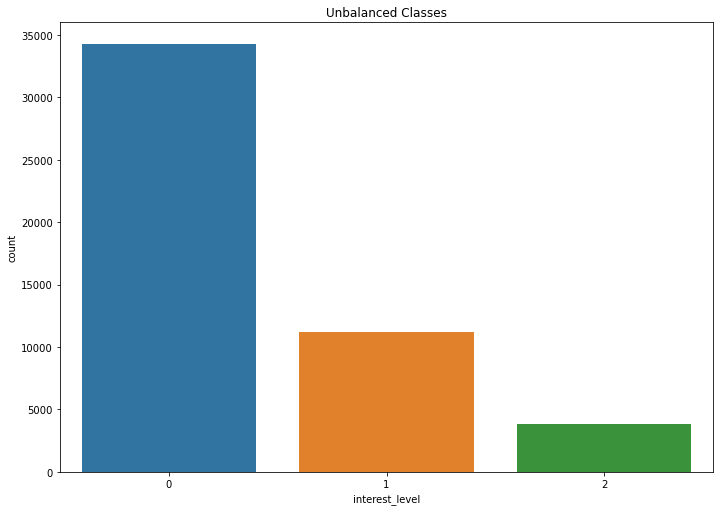

In [4]:
num_vars = ['bathrooms','bedrooms','latitude','longitude','price']
cat_vars = ['building_id','manager_id','display_address','street_address']
text_vars = ['description','features']

rcParams['figure.figsize'] = 11.7,8.27
df['interest_level'] = df['interest_level'].apply(lambda x: 0 if x=='low' else 1 if x=='medium' else 2)
# Check homogeneity of target values
sns.countplot('interest_level', data=df)
plt.title('Unbalanced Classes')
plt.show()

## Data Preprocessing & Feature Engineering

### Feature Engineering

After taking a look at the current features available in the dataset, we notice that there are some variables with which we cannot work just yet. So as a first step, before going into the modeling journey, we decide to do some feature engineering in order to extract some more value from the existing features and create new variables that might help us in the next steps. 

For this section, we used, as a reference, the notebook available in Kaggle called "[TwoSigmaRenthop - Advanced Feature Engineering](https://www.kaggle.com/chriscc/twosigmarenthop-advanced-feature-engineering)". This notebook helped us understand different ways to handle several of the variables present in the notebook to add more value to our project.

#### Categorical Variables

When taking a look into the dataset, we noticed that especially in the address columns, there is a lot of inconsistency. Therefore, we first did basic text cleaning to have a coherent formatting. Additionally, we dropped every row that contains descriptions instead of actuall addresses. These description were identified by searching for ! and * in the address columns.

In [5]:
addresses = ['display_address', 'street_address']

for address in addresses:
    print(address)
    ''' delete rows that contain descriptions instead of actual addresses '''
    address_delete = [] 
    for i in range(len(df)):
        address_val = df[address][i]
        if search('!' or '*', address_val):
            address_delete.append(i)

    df = df.drop(df.index[address_delete])
    print("Num. of deleted addresses: {}".format(
        len(address_delete)))
    
    
    ''' Data Cleaning '''
    address_column = df[address]
    address_column_transformed = ( address_column
                                           .apply(str.upper)
                                           .apply(lambda x: x.replace('WEST','W'))
                                           .apply(lambda x: x.replace('EAST','E'))
                                           .apply(lambda x: x.replace('STREET','ST'))
                                           .apply(lambda x: x.replace('AVENUE','AVE'))
                                           .apply(lambda x: x.replace('BOULEVARD','BLVD'))
                                           .apply(lambda x: x.replace('.',''))
                                           .apply(lambda x: x.replace(',',''))
                                           .apply(lambda x: x.replace('&',''))
                                           .apply(lambda x: x.replace('(',''))
                                           .apply(lambda x: x.replace(')',''))
                                           .apply(lambda x: x.strip())
                                           #.apply(lambda x: re.sub('(?<=\d)[A-Z]{2}', '', x))
                                           .apply(lambda x: re.sub('[^A-Za-z0-9]+ ', '', x)) #remove all special characters and punctuaction
                                           .apply(lambda x: x.replace('FIRST','1'))
                                           .apply(lambda x: x.replace('SECOND','2'))
                                           .apply(lambda x: x.replace('THIRD','3'))
                                           .apply(lambda x: x.replace('FOURTH','4'))
                                           .apply(lambda x: x.replace('FIFTH','5'))
                                           .apply(lambda x: x.replace('SIXTH','6'))
                                           .apply(lambda x: x.replace('SEVENTH','7'))
                                           .apply(lambda x: x.replace('EIGHTH','8'))
                                           .apply(lambda x: x.replace('EIGTH','8'))
                                           .apply(lambda x: x.replace('NINTH','9'))
                                           .apply(lambda x: x.replace('TENTH','10'))
                                           .apply(lambda x: x.replace('ELEVENTH','11'))
                                         )

    print("Num. of Unique Addresses after Transformation: {}".format(
        address_column_transformed.nunique()))

    df[address] = address_column_transformed 

#Count features
display=df["display_address"].value_counts()
manager_id=df["manager_id"].value_counts()
building_id=df["building_id"].value_counts()
street=df["street_address"].value_counts()

df["display_count"]=df["display_address"].apply(lambda x:display[x])
df["manager_count"]=df["manager_id"].apply(lambda x:manager_id[x])  
df["building_count"]=df["building_id"].apply(lambda x:building_id[x])
df["street_count"]=df["street_address"].apply(lambda x:street[x])

#Numeric-categorical interactions (price and building)
price_by_building = df.groupby('building_id')['price'].agg([np.min,np.max,np.mean]).reset_index()
price_by_building.columns = ['building_id','min_price_by_building',
                            'max_price_by_building','mean_price_by_building']
df = pd.merge(df,price_by_building, how='left',on='building_id')
df = df.drop(df.index[address_delete])

OE = OrdinalEncoder()
for cat_var in cat_vars:
    print ("Ordinal Encoding %s" % (cat_var))
    df[cat_var]=OE.fit_transform(df[[cat_var]])

display_address
Num. of deleted addresses: 221
Num. of Unique Addresses after Transformation: 6006
street_address
Num. of deleted addresses: 1
Num. of Unique Addresses after Transformation: 11243
Ordinal Encoding building_id
Ordinal Encoding manager_id
Ordinal Encoding display_address
Ordinal Encoding street_address


#### Text Variables

We decided to also count for some features how often they appear in the dataset. 
<br>Additionally, some numeric-categorial interactions are created with the price and building features by adding some aggregations.
<br>Last step would be to encode all ordinal variables ('building_id','manager_id','display_address','street_address') so that the model can use them as input.

<br> Studies have shown that titles with excessive all caps and special characters give renters the impression 
that the listing is fraudulent – i.e. BEAUTIFUL###APARTMENT###CHELSEA.
We therefore decided to count the number of special characters in the description since it might give a hint for the seriousness of the inquery and hence the interest level. 

<br> Also, new features were derived out of the description by checking whether a phone number or email address is stated

<br> In order to deal with these long text description and to derive some meaningful information out of it, we did some basic text cleaning and then calculated the length, number of words and number of features in the features column.

Finally, for the text features, we counted the appearance of a feature token in the whole dataset using the CountVectorizer from sklearn. For every inquery we then checked if the respective feature was mentioned in the features column or not via One Hot Encoding. To have not every feature in the vocabulary, we limited the size to max features. 

In [6]:
'''
Count number of special characters in description:
Studies have shown that titles with excessive all caps and special characters give renters the impression 
that the listing is fraudulent – i.e. BEAUTIFUL***APARTMENT***CHELSEA.
'''

df['num_of_#']=df.description.apply(lambda x:x.count('#'))
df['num_of_!']=df.description.apply(lambda x:x.count('!'))
df['num_of_$']=df.description.apply(lambda x:x.count('$'))
df['num_of_*']=df.description.apply(lambda x:x.count('*'))
df['num_of_>']=df.description.apply(lambda x:x.count('>'))

#Derive new features (check for phone and email) out of description 
df['has_phone'] = df['description'].apply(lambda x:re.sub('['+string.punctuation+']', '', x).split())\
        .apply(lambda x: [s for s in x if s.isdigit()])\
        .apply(lambda x: len([s for s in x if len(str(s))==10]))\
        .apply(lambda x: 1 if x>0 else 0)

print('Has phone: ' + str(np.round(len(np.where(df['has_phone'] == 1)[0]) / len(df), 2)) + '%')
print('Has no phone: '+ str(np.round(len(np.where(df['has_phone'] == 0)[0]) / len(df), 2)) + '%')

df['has_email'] = df['description'].apply(lambda x: 1 if '@renthop.com' in x else 0)
print('Has email: '+ str(np.round(len(np.where(df['has_email'] == 1)[0]) / len(df), 2))+ '%')
print('Has no email: '+ str(np.round(len(np.where(df['has_email'] == 0)[0]) / len(df), 2))+ '%')

# Count length, num of words and features of description of features 
display_address_column = df['description']
df['description'] = [functions.text_cleaner(x) for x in display_address_column]

df['length_description'] = df['description'].apply(lambda x: len(x))
df['num_words_description'] = df['description'].apply(lambda x: len(x.split(" ")))

df['num_features'] = df['features'].apply(len)

#Extract tokens of features and OHE 
v = CountVectorizer(stop_words='english', max_features=50)
x = v.fit_transform(df['features']\
                                     .apply(lambda x: " ".join(["_".join(i.split(" ")) for i in x])))

df1 = pd.DataFrame(x.toarray(), columns=v.get_feature_names())
df.drop('features', axis=1, inplace=True)
df = df.join(df1.set_index(df.index))

tokens_features = v.get_feature_names()
print(tokens_features)

Has phone: 0.3%
Has no phone: 0.7%
Has email: 0.35%
Has no email: 0.65%
['balcony', 'cats_allowed', 'common_outdoor_space', 'deck', 'dining_room', 'dishwasher', 'dogs_allowed', 'doorman', 'elevator', 'exclusive', 'fireplace', 'fitness_center', 'furnished', 'garage', 'garden', 'green_building', 'hardwood', 'hardwood_floors', 'high_ceilings', 'high_speed_internet', 'laundry', 'laundry_in_building', 'laundry_in_unit', 'laundry_room', 'level', 'live', 'live_in_super', 'loft', 'lowrise', 'multi', 'new_construction', 'no_fee', 'outdoor_space', 'parking_space', 'patio', 'pool', 'pre', 'prewar', 'private_outdoor_space', 'publicoutdoor', 'reduced_fee', 'renovated', 'roof', 'roof_deck', 'simplex', 'site_laundry', 'swimming_pool', 'terrace', 'war', 'wheelchair_access']


#### Date Variables

In the dataset, we have one text variable that refers to the date the rental advertisement was published. In order to use this variable we have to convert it from text to actual datetime type. After we do this, we decide to get some more features from this variable, including the year, month, day of month, day of week, and hour of publication. 

In [7]:
df['created'] = pd.to_datetime(df['created'])
df['created_year'] = df['created'].dt.year
df['created_month'] = df['created'].dt.month
df['created_day_of_month'] = df['created'].dt.day
df['created_day_of_week'] = df['created'].dt.dayofweek
df['created_hour'] = df['created'].dt.hour

#### Image Variables

As the image links doesn't provide any value for the model, we decided to first count the number of photos for every inquery. Also, interactions between number of photos and bedrooms and bathrooms were created.

In [8]:
df['num_photos'] = df['photos'].apply(len)
df['photos_per_bedroom'] = df[['num_photos','bedrooms']].apply(lambda x: x[0]/x[1] if x[1]!=0 else 0, axis=1)
df['photos_per_bathroom'] = df[['num_photos','bathrooms']].apply(lambda x: x[0]/x[1] if x[1]!=0 else 0, axis=1)

#### Numerical Variables

From the previous section, we noticed that we have several numerical variables, and after many of the transformations, we end up with even more of them. Because of this, we decide to create some logical interactions that might have an impact on our model. 

We decide to calculate the total numer of rooms, which is the bedrooms plus the bathrooms. We then decide to calculate the price per room, bedroom and bathroom, where we divide the price by the number of the previously mentioned values. 

In [9]:
df['total_rooms'] = df['bathrooms'] + df['bedrooms']
df['price_per_room'] = df[['price','total_rooms']].apply(lambda x: x[0]/x[1] if x[1] != 0 else 0, axis=1)
df['price_per_bedroom'] = df[['price','bedrooms']].apply(lambda x: x[0]/x[1] if x[1] != 0 else 0, axis=1)
df['price_per_bathroom'] = df[['price','bathrooms']].apply(lambda x: x[0]/x[1] if x[1] != 0 else 0, axis=1)

We also decide to do something similar like before, but this time we calculate the price per word in the word description, as well as the price per length of the description. Moreover, we do the same thing with the features and photos, by calculating the price by each of them. 

In [10]:
df['price_per_word_description'] = df[['price','num_words_description']].apply(lambda x: x[0]/x[1] if x[1] != 0 else 0, axis=1)
df['price_per_length_description'] = df[['price','length_description']].apply(lambda x: x[0]/x[1] if x[1] != 0 else 0, axis=1)
df['price_per_feature'] = df[['price','num_features']].apply(lambda x: x[0]/x[1] if x[1] != 0 else 0, axis=1)
df['price_per_photo'] = df[['price','num_photos']].apply(lambda x: x[0]/x[1] if x[1] != 0 else 0, axis=1)

Finally, we also notice that we have the location of the rented properties. We know that the location usually has an impact on the real estate, so we decide to calculate the distances to some well-known areas of New York City, including the Central Park, Wall Street, and Times Square. In order to calculate the distances, we use a function that we previously defined, that takes the differences of the coordinates and converts the difference into kilometers, so it makes more sense to us. 

In [11]:
central_park_coordinates = (40.7799963,-73.970621)
df['distance_to_central_park'] = df[['latitude','longitude']].apply(
        lambda x: functions.calculate_distance_between_coordinates(central_park_coordinates,(x[0],x[1])), axis=1)

wall_street_coordinates = (40.7059692,-74.0099558)
df['distance_to_wall_street'] = df[['latitude','longitude']].apply(
        lambda x: functions.calculate_distance_between_coordinates(wall_street_coordinates,(x[0],x[1])), axis=1)

times_square_coordinates = (40.7567473,-73.9888876)
df['distance_to_times_square'] = df[['latitude','longitude']].apply(
        lambda x: functions.calculate_distance_between_coordinates(times_square_coordinates,(x[0],x[1])), axis=1)

### Correlation of Features and Target

interest_level           1.000000
building_count           0.199969
created_hour             0.165674
max_price_by_building    0.133916
no_fee                   0.132838
                           ...   
created_month            0.004802
longitude                0.004737
swimming_pool            0.003586
level                    0.001533
multi                    0.001533
Name: interest_level, Length: 91, dtype: float64


<AxesSubplot:>

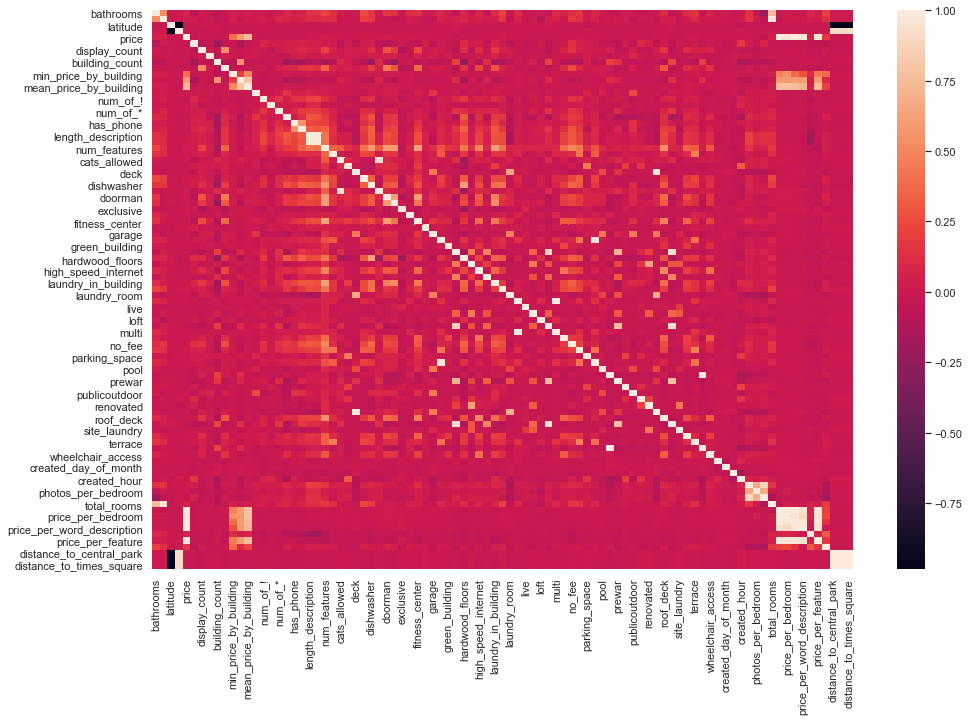

In [12]:
""" Object columns dropped"""
df = df.drop(['building_id', 'listing_id', 'description', 'created', 'created_year','display_address', 'manager_id', 
              'photos', 'street_address'], axis=1) 

# Convert target values into ordinal values 

df_corr = df.corr()
df_corr_abs = np.abs(df_corr['interest_level'])

df_corr_abs_sort = df_corr_abs.sort_values(ascending = False)
print(df_corr_abs_sort)

sns.set(rc={'figure.figsize':(15.7,10.27)})
sns.heatmap(df.corr())

## Model Performance & Hyper-Parameter Tuning

### Splitting of the Dataset

Having performed the feature engineering and decided that our dataset is ready to be modeled, we first have to split our dataset into training and testing set. For this case, we first separate our independent variables (X) from our target variable (y). Since we are going to be using cross-validation, we decide to split only into training and testing set, without manually splitting also into a validation set, which will be created automatically during the cross-validation. As a testing size, we decide to use 15% of the data. 

In [13]:
X = df.drop("interest_level", axis=1)
y = df["interest_level"]

X_train, X_test, y_train , y_test = train_test_split(X, y, test_size=0.15)

### Feature Selection

After performing data engineering and creating new variables, we end up with 91 variables in total. For this reason, we decided the next step to be feature selection. To avoid overfitting, this procedure is performed only in the training set. It is worth mentioning that in this case, we did not define any parameter for the random forest.
What we are using is selectFromModel object from sklearn. It will select only those features which importance is greater than the mean importance of all features. This method is considered to be straightforward, fast and accurate.
The results that we will get are 31 features only.

In [15]:
sel = SelectFromModel(RandomForestClassifier())
sel.fit(X_train, y_train)


#To see which feature are important
sel.get_support()


#to get the number of important features
selected_feat= X_train.columns[(sel.get_support())]
len(selected_feat)


#to get the name of feature selected
print(selected_feat)


X_train= X_train[selected_feat]
X_test= X_test[selected_feat]


Index(['latitude', 'longitude', 'price', 'display_count', 'manager_count',
       'building_count', 'street_count', 'min_price_by_building',
       'max_price_by_building', 'mean_price_by_building', 'num_of_!',
       'num_of_>', 'length_description', 'num_words_description',
       'num_features', 'no_fee', 'created_month', 'created_day_of_month',
       'created_day_of_week', 'created_hour', 'num_photos',
       'photos_per_bedroom', 'photos_per_bathroom', 'price_per_room',
       'price_per_bedroom', 'price_per_bathroom', 'price_per_word_description',
       'price_per_length_description', 'price_per_feature', 'price_per_photo',
       'distance_to_central_park', 'distance_to_wall_street',
       'distance_to_times_square'],
      dtype='object')


In [13]:
'''
df = df[['latitude', 'longitude', 'price', 'display_count', 'manager_count',
       'building_count', 'street_count', 'min_price_by_building',
       'max_price_by_building', 'mean_price_by_building', 'num_of_!',
       'num_of_>', 'length_description', 'num_words_description',
       'num_features', 'no_fee', 'created_month', 'created_day_of_month',
       'created_day_of_week', 'created_hour', 'num_photos',
       'photos_per_bedroom', 'photos_per_bathroom', 'price_per_room',
       'price_per_bedroom', 'price_per_bathroom', 'price_per_word_description',
       'price_per_length_description', 'price_per_feature', 'price_per_photo',
       'distance_to_central_park', 'distance_to_wall_street',
       'distance_to_times_square', 'interest_level']]

X = df.drop("interest_level", axis=1)
y = df["interest_level"]

X_train, X_test, y_train , y_test = train_test_split(X, y, test_size=0.15)
'''

### Hyperparameter Tuning  for the Random Forest

Now that we have our best features, next step is optimizing the random forest model. Our idea was to test on a wide range of values for each hyperparameter, that is why we decided to use Random Search Cross Validation from scikit-learn. It is considered to perform better in large datasets and in general picks the best result more often than other method. The range of values can be seen in the created parameter grid.

In [16]:
# Number of trees in random forest
n_estimators = np.arange(start=100, stop=2001, step=10)
 #Number of features to consider at every split'''
max_features = ['auto', 'sqrt']
 #Maximum number of levels in tree'''
max_depth = np.arange(start=10, stop=111, step=5)
#max_depth.append(None)
 #Minimum number of samples required to split a node'''
min_samples_split = np.arange(start=2, stop=101)
 #Minimum number of samples required at each leaf node'''
min_samples_leaf = np.arange(start=2, stop=101)
#Method of selecting samples for training each tree'''
bootstrap = [True, False]


'''Create the random grid'''
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


'''First create the base model to tune'''

rf = RandomForestClassifier()

''' Use the random grid to search for best hyperparameters'''
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 20, cv = 5, verbose=2, 
                               random_state=123, n_jobs = -1)

'''Fit the random search model'''
rf_random.fit(X_train, y_train)

print('test')

best_params = rf_random.best_params_

print(best_params)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 42.8min finished


test
{'n_estimators': 1150, 'min_samples_split': 71, 'min_samples_leaf': 6, 'max_features': 'auto', 'max_depth': 85, 'bootstrap': False}


### Pruning of the Decision Tree
Now we are going to create another model: Decision Tree. Firstly, a decision tree is created by using gini as a criterion. Obviously, we will have overfitting because the model will be trained in its maximum depth. That is why now we go to the second step, pruning the tree. To prune the tree, we need to find the best alpha, which describes how much or how little the tree should be pruned, by deleting unnecessary branches.

Accuracy :  66.87924016282226
Accuracy :  72.3202170963365


Text(704.984469126506, 895.2412500000002, 'street_count <= 8897.5\ngini = 0.46\nsamples = 41759\nvalue = [29002, 9506, 3251]\nclass = Low Interest')

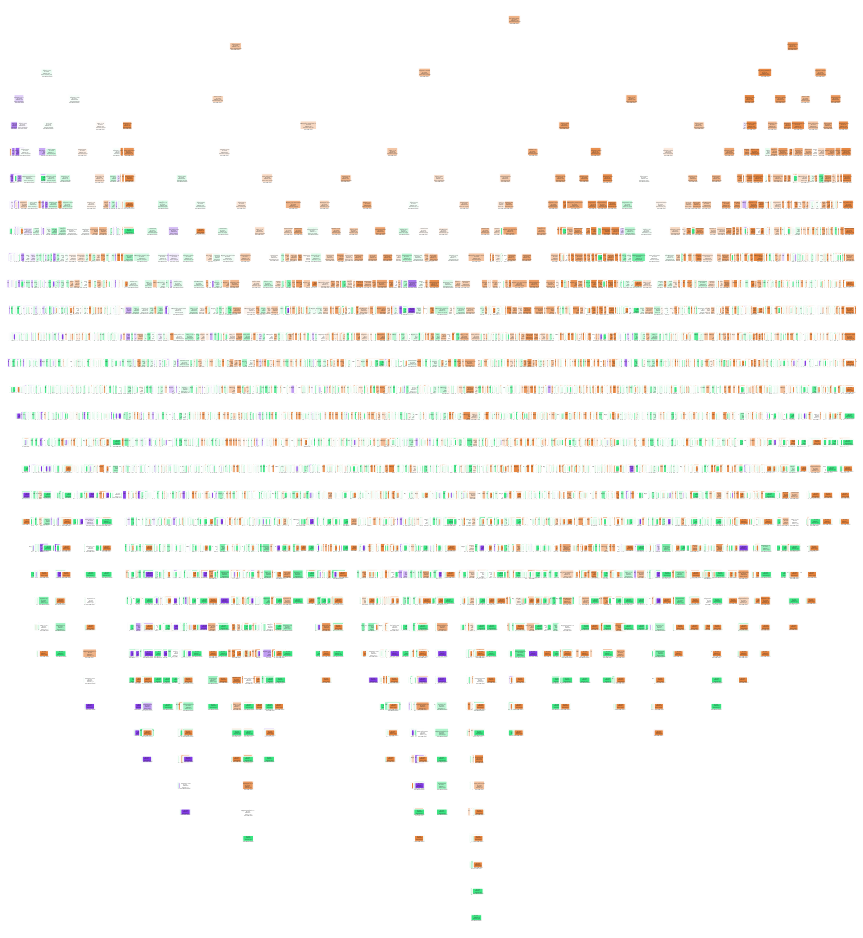

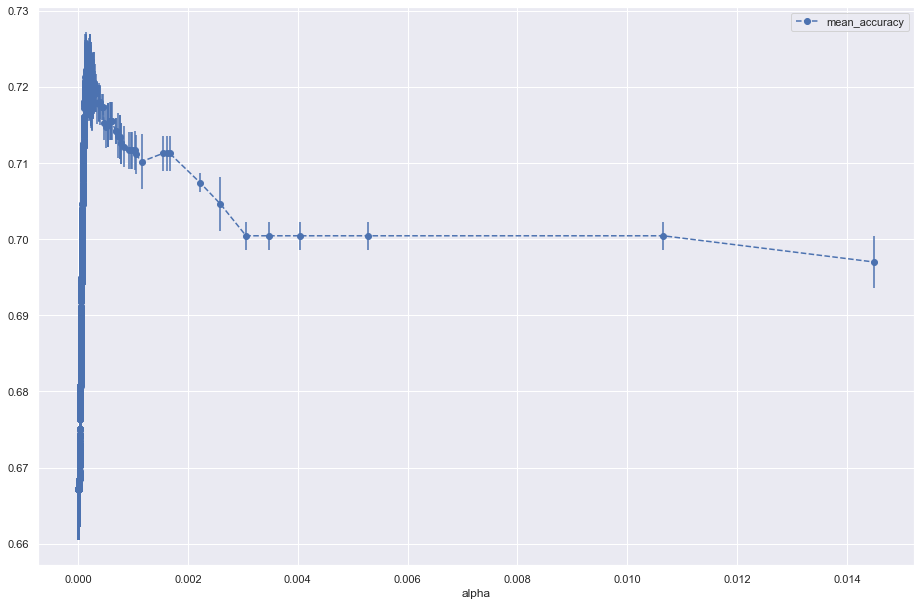

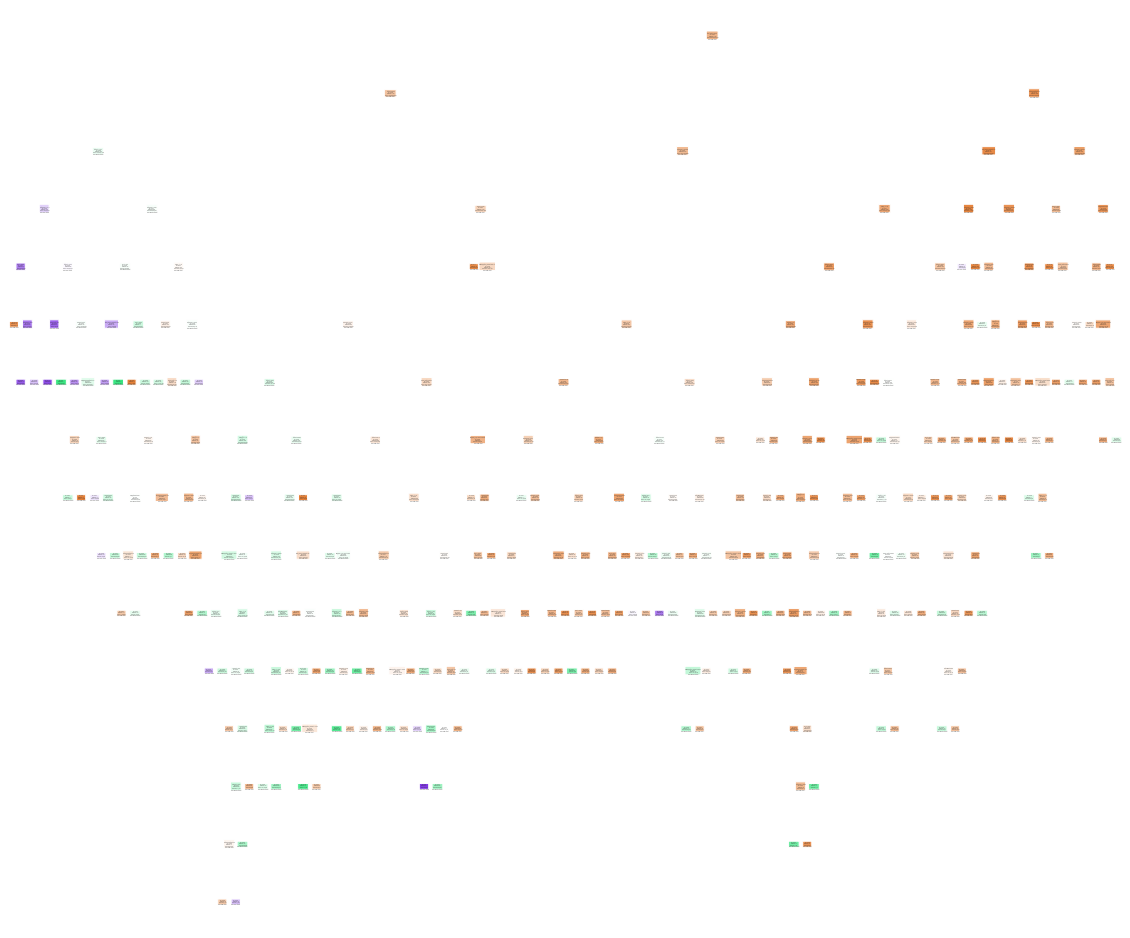

In [19]:
tree = DecisionTreeClassifier(criterion = "gini", random_state = 123) 
tree = tree.fit(X_train, y_train) 
y_pred = tree.predict(X_test) 
print ("Accuracy : ", accuracy_score(y_test,y_pred)*100) 



#ploting the tree

from sklearn.tree import plot_tree
plt.figure(figsize = (15,17))
plot_tree(tree, filled = True, rounded = True, class_names = ['Low Interest', 'Medium Interest', 'High Interest'], feature_names = X.columns)[0]

#determine values for alpha
path = tree.cost_complexity_pruning_path(X_train, y_train)

#extract different values for alpha
ccp_alphas = path.ccp_alphas 
ccp_alphas = ccp_alphas[:-1]


#create an array to store the resuls of each fold during cross validation
alpha_loop_values = []

# For each candidate value alpha, we will run 5-fold cross validation
# Then we will store the mean and std of the scores(accuracy) for each call
# to cross_val_score in alpha_loop_values...

for ccp_alpha in ccp_alphas:
    tree = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    scores = cross_val_score(tree, X_train, y_train, cv=5)
    alpha_loop_values.append([ccp_alpha, np.mean(scores), np.std(scores)])
#Now we can draw a graph of the means and std of the scores
#for each candidate value for alpha
alpha_results = pd.DataFrame(alpha_loop_values, 
                             columns=['alpha', 'mean_accuracy', 'std'])

alpha_results.plot(x='alpha',
                   y='mean_accuracy',
                   yerr = 'std',
                   marker = 'o',
                  linestyle ='--')


#Printing the best alpha

column = alpha_results["mean_accuracy"]
max_index = column.idxmax()
max_index


ideal_ccp_alpha = alpha_results.iloc[max_index]['alpha']
#ideal_ccp_alpha 
#Prunning the classification tree

tree_pruned = DecisionTreeClassifier(random_state = 123,
                                    ccp_alpha=ideal_ccp_alpha)
tree_pruned = tree_pruned.fit(X_train, y_train)




y_pred = tree_pruned.predict(X_test) 
print ("Accuracy : ", accuracy_score(y_test,y_pred)*100) 

#plotting the best tree
plt.figure(figsize = (20,17))
plot_tree(tree_pruned, filled = True, rounded = True,class_names = ['Low Interest', 'Medium Interest', 'High Interest'], feature_names = X.columns)[0]

### Model Selection

To select the most suitable model for this project, we trained the models tuned above with the best parameters gotten. In the end, Random Forest came in first with 
a log_loss of 57.64%, and test accuracy of approximately 74%.

Hence, Random forest was choosen as our model for the rest of the tasks completed in this project

In [20]:
#Defining model parameters from the tuned parameter
model_params = {
    'random_forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': best_params['n_estimators'],
            'min_samples_split': best_params['min_samples_split'],
            'min_samples_leaf': best_params['min_samples_leaf'],
            'max_features': best_params['max_features'],
            'max_depth': best_params['max_depth'],
            'bootstrap': best_params['bootstrap']
        }
    },
    
    'decision_tree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'ccp_alpha': ideal_ccp_alpha
        }
    },
    
}

#Loop over both decision tree and random forest to determine the best model for the given dataset
scores = []
print(model_params.items())

trained_models = []
for model_name, mp in model_params.items():
    clf = mp['model']
    clf.set_params(**mp['params'])
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)
    scores.append({
        'model': model_name,
        'train_score': clf.score(X_train, y_train),
        'test_score': clf.score(X_test, y_test),
        'log_loss': log_loss(y_test, y_pred)
    })
    trained_models.append(clf)
    
best_model = pd.DataFrame(scores, columns= ['model','train_score','test_score', 'log_loss'])
print(best_model)

rf = trained_models[0]

dict_items([('random_forest', {'model': RandomForestClassifier(), 'params': {'n_estimators': 1150, 'min_samples_split': 71, 'min_samples_leaf': 6, 'max_features': 'auto', 'max_depth': 85, 'bootstrap': False}}), ('decision_tree', {'model': DecisionTreeClassifier(), 'params': {'ccp_alpha': 0.00015038018043321772}})])
           model  train_score  test_score  log_loss
0  random_forest     0.816327    0.746404  0.576432
1  decision_tree     0.750736    0.723202  0.667657


In [14]:
'''
rf = RandomForestClassifier(n_estimators=1150, min_samples_split=71, min_samples_leaf=6, max_features='auto', max_depth=85, bootstrap=False)
rf.fit(X_train, y_train)
y_pred = rf.predict_proba(X_test)

print("train_acc: ", rf.score(X_train, y_train))
print("test_acc: ", rf.score(X_test, y_test))
print("log_loss: ", log_loss(y_test, y_pred))
'''

train_acc:  0.8186498718839053
test_acc:  0.7449118046132972
log_loss:  0.5795788319372878


## Prediction Explanation & Story Telling

Now that we have our best model, we will get to know it more. In this section will be covered Gini Importance or Mean Decrease in Impurity (MDI), Permutation Importance or Mean Decrease in Accuracy, Partial Dependency Pots and SHAP values.

### Feature Importance

Feature importance shows what variables most affect predictions. The code below will perform both MDI and MDA. The first one will show us how effective the feature is at reducing uncertainty when creating a decision tree. From the other side, MDA will permutate feature data and then test how much that affects the model accuracy. If changing the dataset drops accuracy, then the feature is considered to be important.
Results for this will be seen in the plots and final result table that we ploting.


                         Feature  Gini Importance  Permutation Importance
0                       latitude         0.023411                0.009800
1                      longitude         0.026853                0.012000
2                          price         0.075297                0.042200
3                  display_count         0.022640                0.009600
4                  manager_count         0.017667                0.008800
5                 building_count         0.043804                0.015400
6                   street_count         0.015527                0.007600
7          min_price_by_building         0.048068                0.013000
8          max_price_by_building         0.077176                0.022800
9         mean_price_by_building         0.056967                0.020400
10                      num_of_!         0.007608                0.003800
11                      num_of_>         0.014912                0.009000
12            length_description      

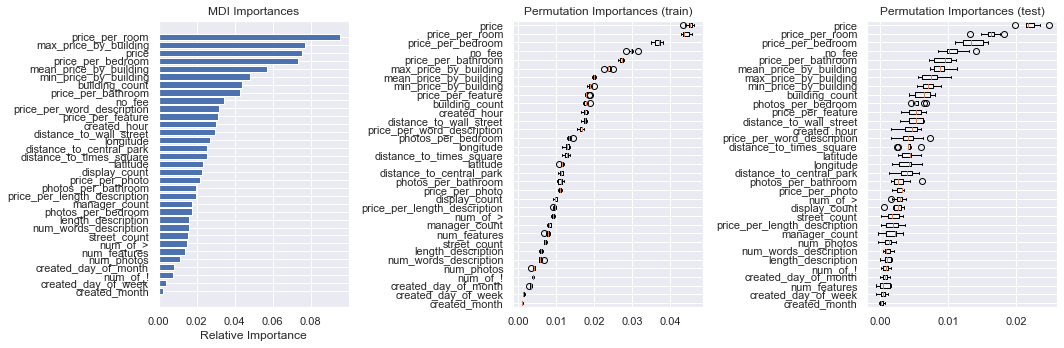

In [21]:
#MDI
MDI_importances = rf.feature_importances_
indices = np.argsort(MDI_importances)
features = X_train.columns

#MDA
MDA_test = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=123)
sorted_idx1 = MDA_test.importances_mean.argsort()
MDA_train = permutation_importance(rf, X_train, y_train, n_repeats=10, random_state=123)
sorted_idx2 = MDA_train.importances_mean.argsort()

#Plotting
plt.rcParams["figure.figsize"]=15,5
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.set_title('MDI Importances')
ax1.barh(range(len(indices)), MDI_importances[indices], color='b', align='center')
ax1.set_yticks( np.arange(len(X_train.columns)))
ax1.set_yticklabels(features[indices])
ax1.set(xlabel='Relative Importance')
ax2.boxplot(MDA_train.importances[sorted_idx2].T,
vert=False, labels=features[sorted_idx2])
tpmp=ax2.set_title("Permutation Importances (train)")
ax3.boxplot(MDA_test.importances[sorted_idx1].T,
vert=False, labels=features[sorted_idx1])
tpmp=ax3.set_title("Permutation Importances (test)")
fig.tight_layout()

#Table of results
# record times for comparison
t0 = time()
# Gini importance
gini_imp = pd.DataFrame({'Feature': X_train.columns, 'Gini Importance': rf.feature_importances_}).set_index('Feature')

t1 = time()# Permutation importance for train
perm_imp = importances(rf, X_train, y_train)

t2 = time()
res= gini_imp.merge(perm_imp, left_index=True, right_index=True).reset_index().\
        rename(columns={'Importance': 'Permutation Importance'})
res.loc[len(X_train.columns)+1] = ['runtime(s)', t1-t0, t2-t1]

print(res)

top5_feat = res[:-1].sort_values(by=['Permutation Importance'], ascending=False).head(5)
print('Top 5 features with higher importance:', top5_feat)

Explain what pdp-s are

In [15]:
d = {'Feature': ['price', 'price_per_room', 'no_fee', 'price_per_bedroom', 'price_per_bathroom']}
top5_feat = pd.DataFrame(d)

In [17]:
#Function for ploting PDP 
def ploting_pdp (f):
    pdp_surv = pdp.pdp_isolate(model=rf, dataset=X_train, model_features=X_train.columns, feature=f, cust_grid_points=None)
    pdp.pdp_plot(pdp_surv, f)
    plt.show()


#Function for plotting a two dimension PDP
def two_dim_pdp(f):
    inter= pdp.pdp_interact(model=rf, dataset=X_train, model_features=X_train.columns, features=f)
    pdp.pdp_interact_plot(pdp_interact_out=inter, feature_names=f, plot_type='grid')   
    plt.show()


#Summary plot of SHAP Values
def shap_summary(model, train_set):  
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(train_set)
    res = shap.summary_plot(shap_values, train_set)
    return res

#Dependency contribution plots
def dependency_contribution(f, i):
    explainer = shap.TreeExplainer(rf)  
    shap_values = explainer.shap_values(X_train)  
    res = shap.dependence_plot(f, shap_values[i], X_train)
    return res



#Function for forceplots
def forceplots(row_to_show, interest_class):
    data_for_prediction = X_train.iloc[row_to_show]
    data_for_prediction_array = data_for_prediction.values.reshape(1, -1)
    rf.predict_proba(data_for_prediction_array)
    explainer = shap.TreeExplainer(rf)
    shap_values = explainer.shap_values(data_for_prediction)
    shap.initjs()
    res = shap.force_plot(explainer.expected_value[interest_class], shap_values[interest_class], data_for_prediction)
    return res



'''-------------------------- Selecting the Top Correlations ------------------------------'''

def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

### Partial Dependence Plots

Partial dependence plots show how each feature affects the model's predictions. It is always calculated after the model has been trained. In our case, since we are dealing with multiclass classification, each feature will have three different plots, one for each class. Because we have a lot of feature, we will plot and interpret PDPD plots for top 5 important features only.

It is important to be mentioned that:

1. The y axis is interpreted as change in the prediction from what it would be predicted at the baseline or leftmost value.
2. A blue shaded area indicates level of confidence

In the beginning, we decided to plot PDPs for top five. But, since we did not get any very insightful results, we decided to run pdp-s for features that sounded interesting for us.

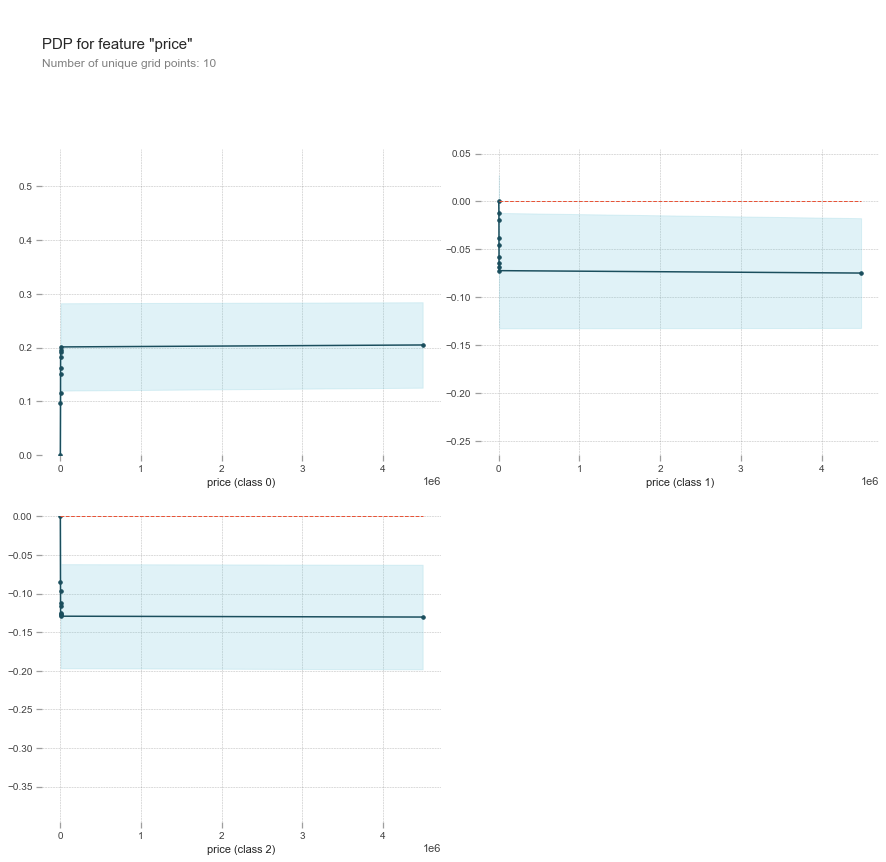

In [17]:
ploting_pdp(f=top5_feat.iloc[0,0])

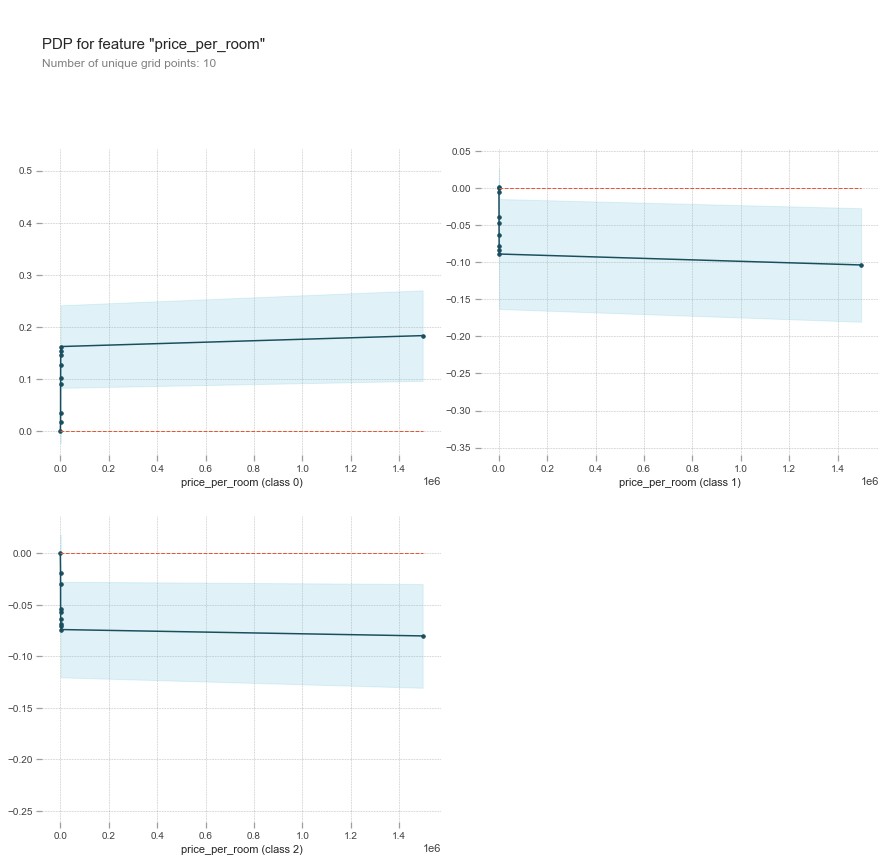

In [18]:
ploting_pdp(f=top5_feat.iloc[1,0])

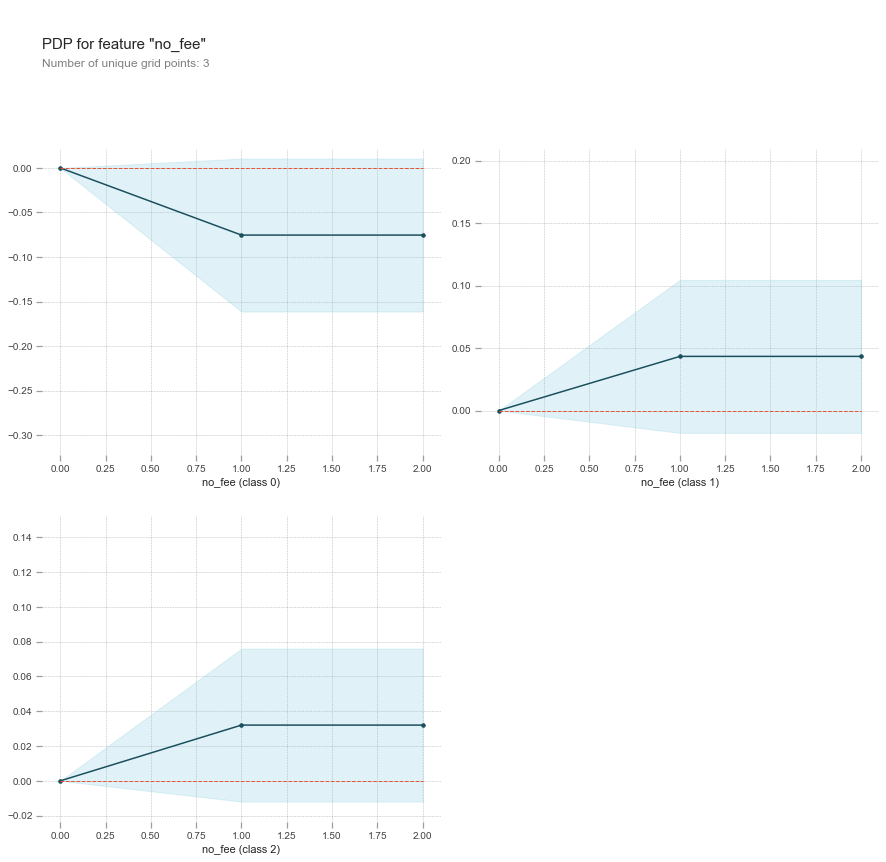

In [19]:
ploting_pdp(f=top5_feat.iloc[2,0])

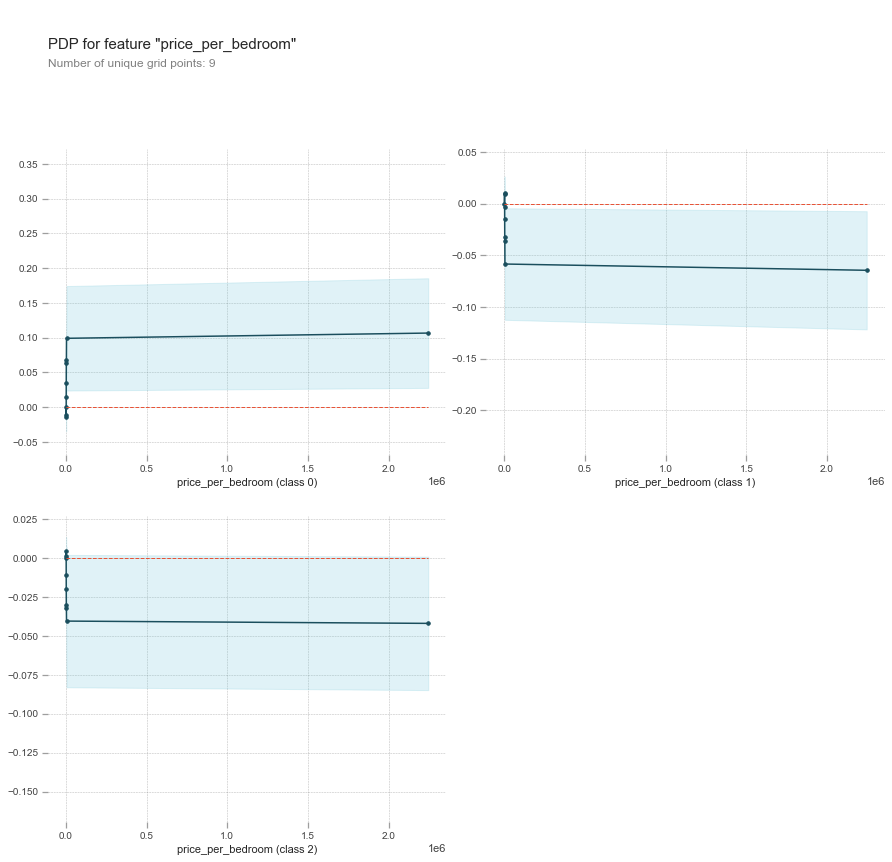

In [20]:
ploting_pdp(f=top5_feat.iloc[3,0])

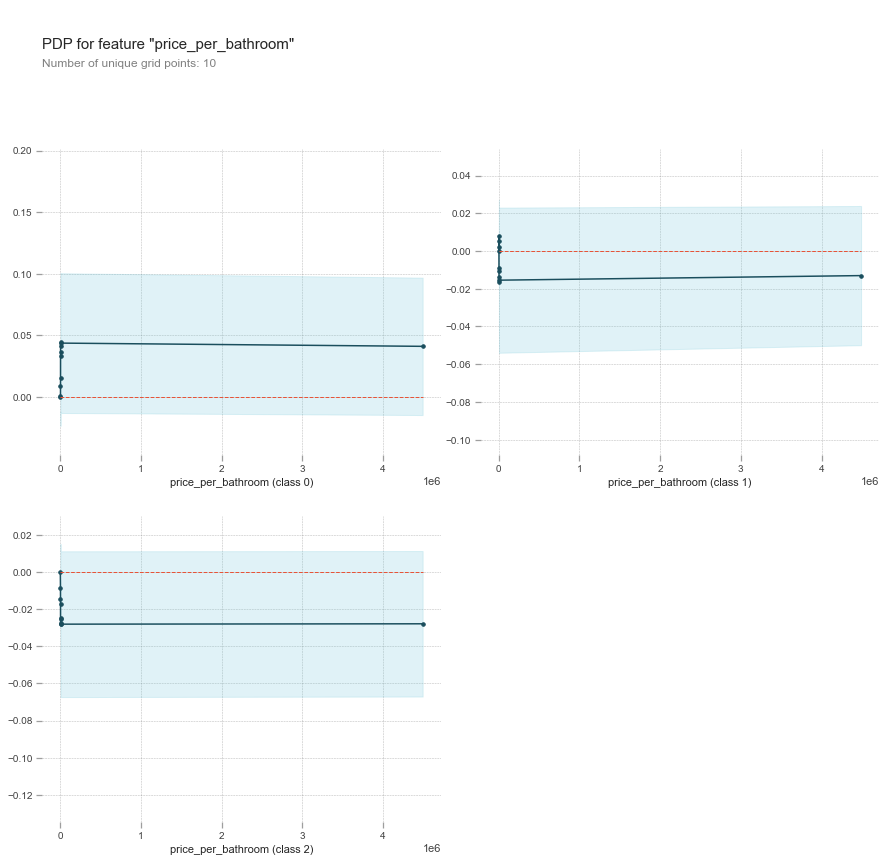

In [21]:
ploting_pdp(f=top5_feat.iloc[4,0])

Analyzing 5 more interesting features, we reached the following conclusions:

In [ ]:
ploting_pdp(f='num_of_!')

Result: Increasing number of “!” until 5, increases the level of interest. 
After 5, level of interest slowly increases. 

The more emphasis is placed on descriptions, a gradual increase in level of interest is observed

In [ ]:
ploting_pdp(f='num_features')

Additional number of feature increases the level of interest. This trend peaks as the number of features reaches 12. 

In [ ]:
ploting_pdp(f='created_hour')

Adverts posted between 00:00 to 04:00 attracts low level of interest which makes sense because most New Yorkers could be partying or sleeping at this time period

In [ ]:
ploting_pdp(f='photos_per_bathroom')

The more bathroom pictures a posting has, the higher the interest level. Though our analysis shows that having more than 10 photos of the bathroom is unnecessary

In [ ]:
ploting_pdp(f='no_fee')

Everybody love freebies, as expected, when fees are not charged for most perks and features the interest level increases. The reverse is the case when fees are chareged.

PDPs assume no correlation between independent variables, but we might be curious about interactions between features. Here is when two-dimensional partial dependence plot is useful. What we will do next is that we will get top five correlated features and right after that, we will plot and interpret the results.  

In [36]:
get_top_abs_correlations(X_train, n=5)

distance_to_central_park  distance_to_times_square    0.999861
distance_to_wall_street   distance_to_times_square    0.999678
distance_to_central_park  distance_to_wall_street     0.999260
price                     price_per_bathroom          0.996493
length_description        num_words_description       0.991049
dtype: float64

Now that we have top five correlated features, let's take a look at the plots.

As we can see, we will get three plots, one for each class. These graphs show predictions for any combination of Distance to central park and Distance to time square.

First thing to notice is that the interaction of these two features, predicts mostly that we have a low interest. So, it looks like medium and hight interest is not impacted that much from the correlation between two features.

Looking at the plot with low interest, we see that when distance from time square is at least 5 km, prediction to have low interest increases. In this case, distance from central park does not matter that much. For a better undertsanding, check the results when distance to time square is 9.3 and distance to central park goes from 2.9 to 9.3.

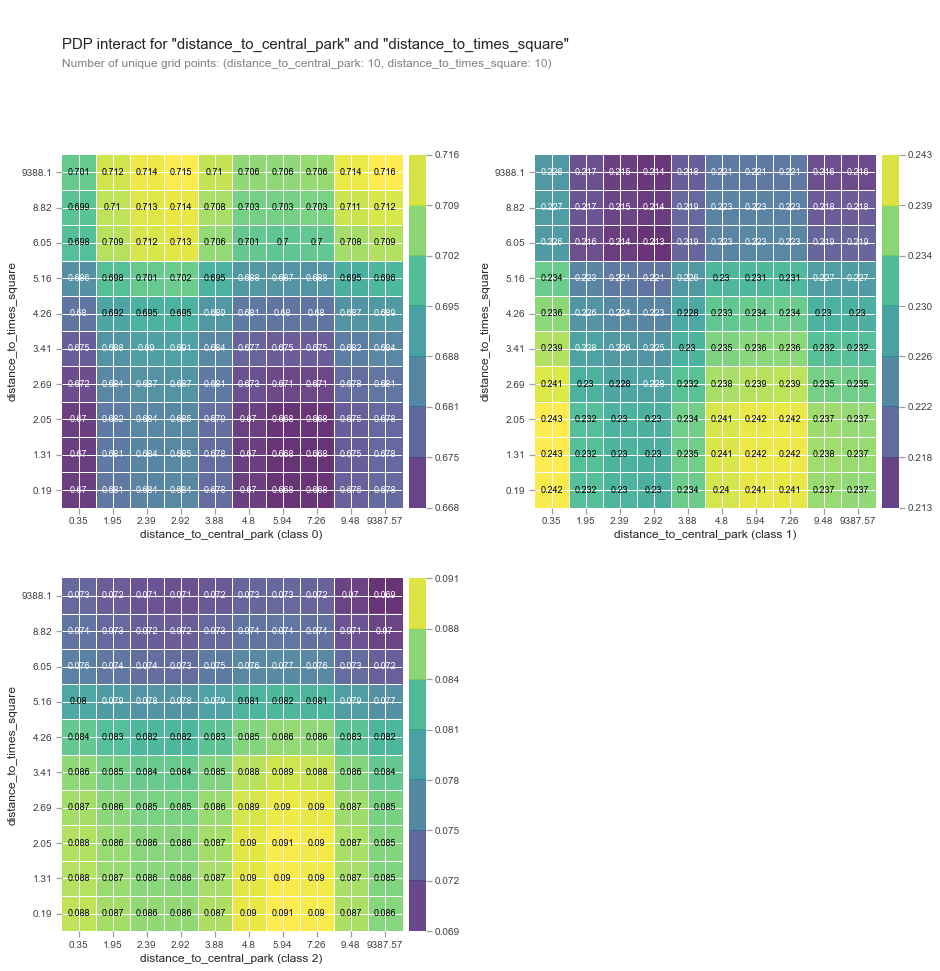

In [37]:
#Plot 2 dimension pdp for top 5 correlations
features_to_plot = ['distance_to_central_park', 'distance_to_times_square'] #manually add the top 5 features
two_dim_pdp(f=features_to_plot)

Also in the case of distance to wall street and distance to times square, the correlation predicts mostly that we have low interest. In the case of low interest class, the tendency is that, as both features increase, the chances to have a lower interest increase too. Meanwhile the opposite happens in the two other plots. As both features' value increase, the chances to have a medium or high interest, decrease. 

Conslusion: As distance to wall street and distance to time square increases, interest level decreases.

Now we can see how the correlation between distance to central park and distance to wall street impact final results. In these case we cannot find a general patern, but still there are some interesting shapes and behaviours to take a look at.

As in the three other cases, even here we can say that these features mostly predict to have a low interest. What is intersting to see is that, for distance to central park from 1-3 km, as distance to wall street increases, chances to have low interst also increases and chances to have high interest decreases. Meanwhile, for distance to central park from  5-7km and distance to wall street from 1-4km, we have the highest level of interest. The fact that we cannot define a specific behaviour, might also come because of other correlations. Unfortunately, PDP-s are limited to only two dimensional view.

What we can understand from until know, is that in general, when it come to distance to a specific important point in the city, if it increases, level of interest decreases.

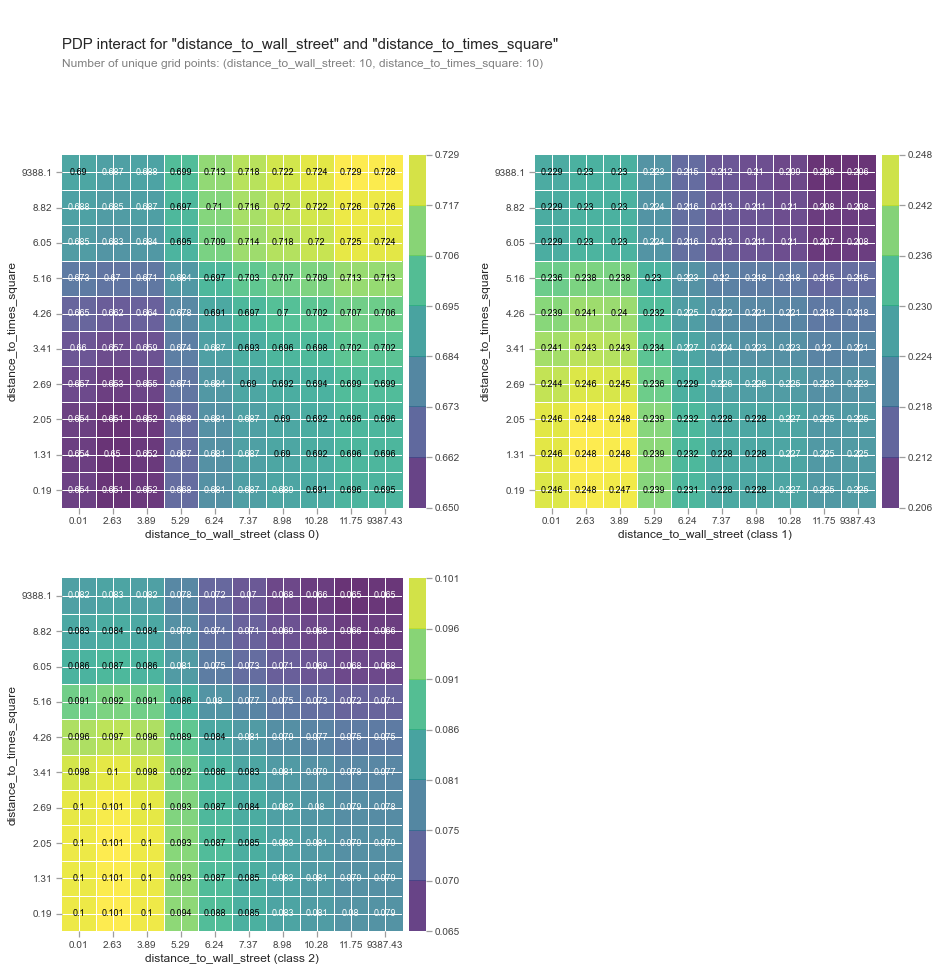

In [38]:
#Plot 2 dimension pdp for top 5 correlations
features_to_plot = ['distance_to_wall_street', 'distance_to_times_square']
two_dim_pdp(f=features_to_plot)

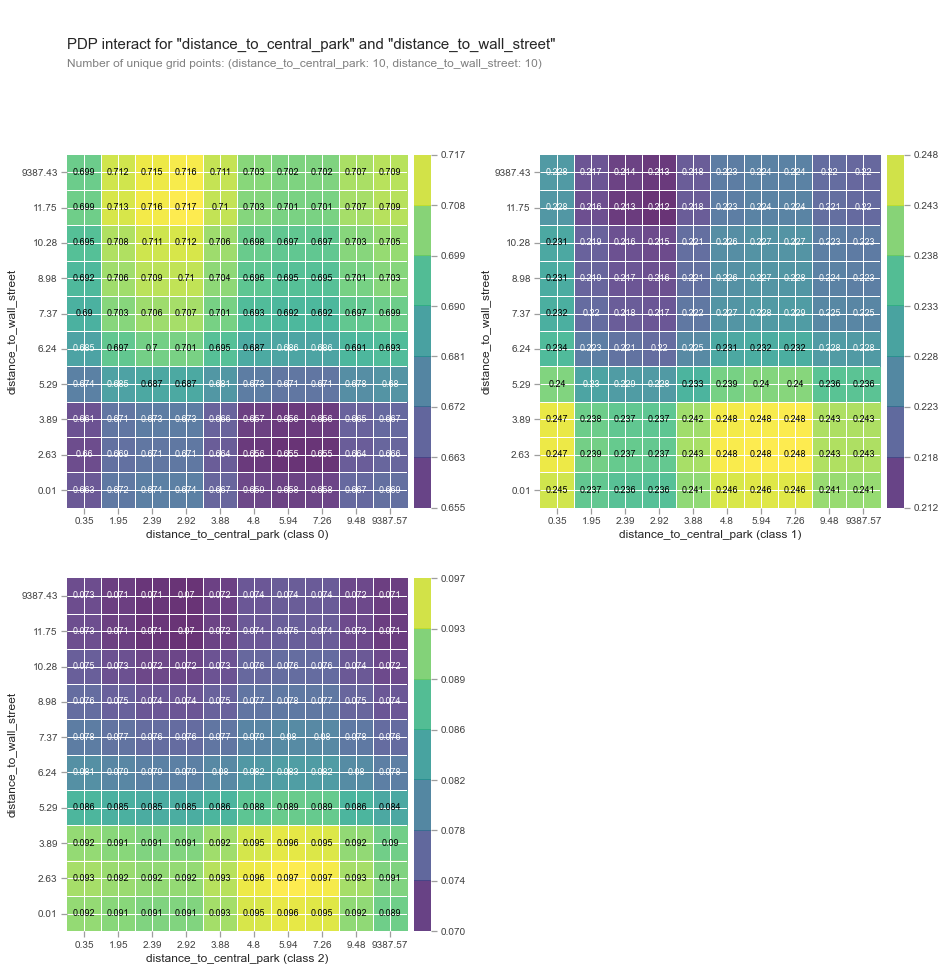

In [39]:
#Plot 2 dimension pdp for top 5 correlations
features_to_plot = ['distance_to_central_park', 'distance_to_wall_street']
two_dim_pdp(f=features_to_plot)

Exlain result 3

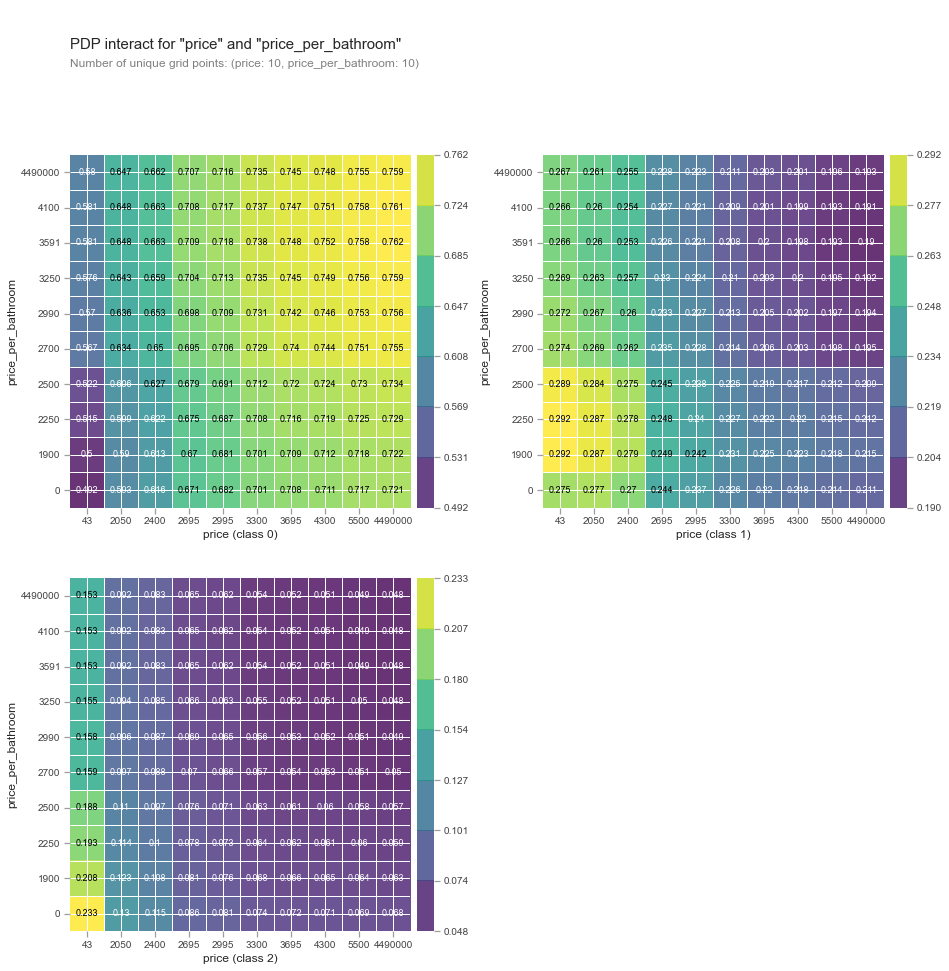

In [40]:
#Plot 2 dimension pdp for top 5 correlations
features_to_plot = ['price', 'price_per_bathroom']
two_dim_pdp(f=features_to_plot)

PDPs for price and price per bathrooms, seems to give some interesting insights. What can be noticed is that, for price starting from 1025 and up, the level of interest will decrease as the price increase. Price per bathroom does not seem to play any role in here. Then, for price less than 1025, as price per bathroom increases, level of interest also decreases. 

From our personal understanding, it also makes sense that people first check the total price and determine their level of interest based on that. Price per bathroom can be a second factor to be considered.

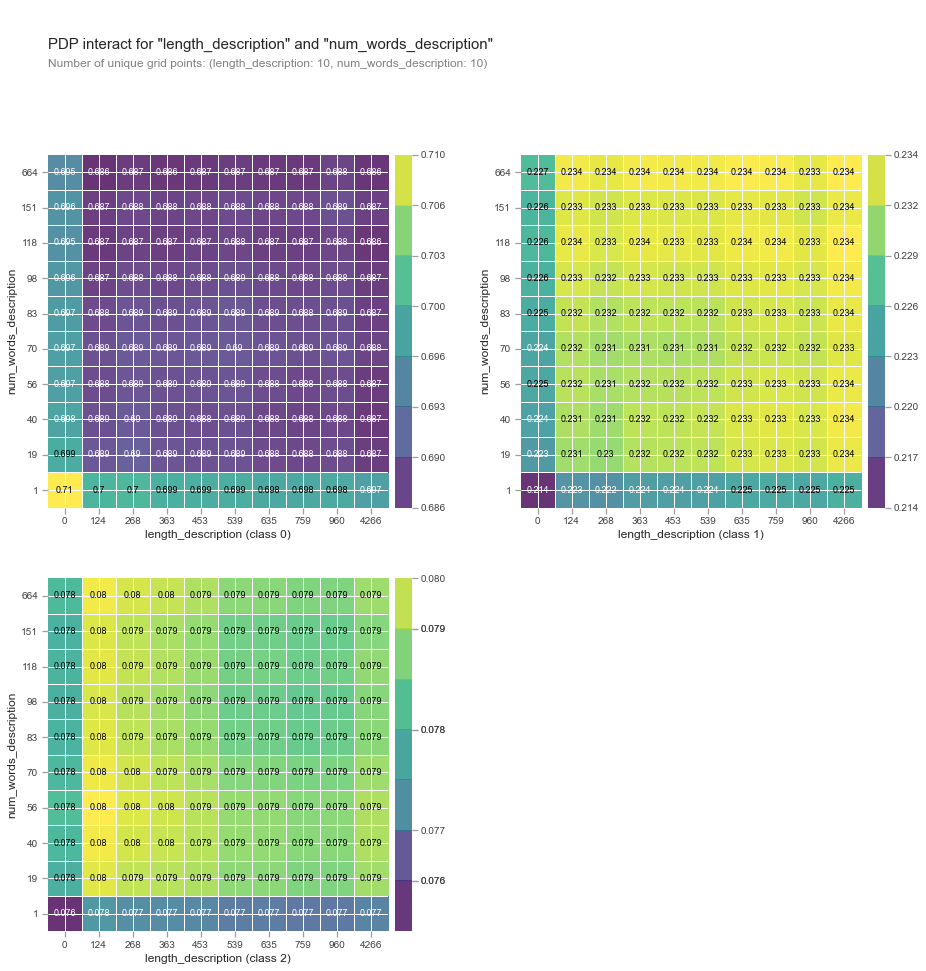

In [41]:
#Plot 2 dimension pdp for top 5 correlations
features_to_plot = ['length_description', 'num_words_description']
two_dim_pdp(f=features_to_plot)

Length Description and Number of Words per Description are listed as features with a high correlation. First obvious thing to notice here is that when description has 10 words and less than 62 characters, the level of interest is very low. After that, as they increase, there is a very slow increasement in the level of interest too, but it does not make any big difference. 

Another thing to notice is that, when we keep number of words per description  to ten words, but we use long words (length of description increases), level of interest increases. From the other side, if we keep number of characters less than 62 and increase number of words, level of interest increases too. What we can understand from this part, is that people like to have a detailed description, but until an exact point.


SHAP Values measure the contribution each feature has in a machine learning model, in our case random forest. The show how much a given feature changed our prediction.

First thing to plot is SHAP summary plot. It will summarize feature importance and what is driving it. Let's go through it using our model.

In [19]:
shap_feat = X_train[['price', 'no_fee', 'distance_to_wall_street', 'price_per_word_description', 'photos_per_bathroom', 'created_hour', 'manager_count', 'num_photos', 'price_per_bedroom', 'length_description']]
shap_feat = shap_feat.sample(10000, replace=False)

In [20]:
shap_feat.shape

(10000, 10)

In [ ]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(shap_feat, check_additivity=False)
res = shap.summary_plot(shap_values, shap_feat)

In [ ]:
shap_summary(rf, shap_feat)

Explain results

After getting an overview of the model, we can go deeper by checking how a single feature contributes in our model. Here is when we use SHAP dependence contribution plot. They provide a similar insight to PDP's, but they add a lot more detail. For this reason, we will use the same features that we already used for PDP’s plots and compare the results.

In [ ]:
dependency_contribution(f=top5_feat.iloc[0,0], i=0)

Explain result 1

In [ ]:
dependency_contribution(f=top5_feat.iloc[0,0], i=1)

Explain result 2

In [ ]:
dependency_contribution(f=top5_feat.iloc[0,0], i=2)

Explain result 3

In [ ]:
dependency_contribution(f=top5_feat.iloc[1,0], i=0)

Explain result 4

In [ ]:
dependency_contribution(f=top5_feat.iloc[1,0], i=1)

Explain result 5

In [ ]:
dependency_contribution(f=top5_feat.iloc[1,0], i=2)

Explain result 6

Last thing to be covered in this part are forceplots. They break down a prediction to show the impact of each feature and why our prediction was different from the baseline. In our case, we will randomly choose an instance and a class, and interpret the results.

In [ ]:
n = np.random.randint(1,df.shape[0]+1)
m = np.random.randint(0,3)
forceplots(n, m)

Explain the results

## Extras

### Neural Network 

In [ ]:
n_classes = len(np.unique(y))
n_features = X_train.shape[1]

ffnn = Sequential()
ffnn.add(Dense(256, activation='relu', input_shape=(n_features,)))
ffnn.add(Dropout(0.3))
ffnn.add(Dense(64, activation='relu'))
ffnn.add(Dense(32, activation='relu'))
ffnn.add(Dense(n_classes, activation='softmax'))

ffnn.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.Adam(lr=0.0001),
              metrics=['accuracy'])
ffnn.summary()

trained_ffnn = ffnn.fit(X_train, y_train,
          validation_data = (X_test, y_test),
          epochs=50, 
          batch_size=8, 
          verbose=1
         )

rcParams['figure.figsize'] = 10, 5
plt.plot(ffnn.history.history['loss'], label = "Train Loss")
plt.plot(ffnn.history.history['val_loss'], label = "Test Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.plot()

rcParams['figure.figsize'] = 10, 5
plt.plot(ffnn.history.history['accuracy'], label = "Train Accuracy")
plt.plot(ffnn.history.history['val_accuracy'], label = "Test Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.plot()

Working on this project and testing the results on subsets of the dataset produced the desired results, but when it got to combining all the different notebooks together, we experienced a lot of delay in running the SHAP Values, due to time pressure, we handed in this incompletely ran notebook, but will also send the completely ran notebook via email. 